# An Introduction to Probabilistic Programming in FSharp

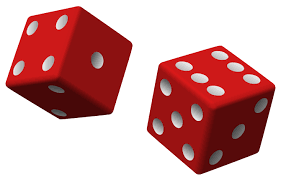

## Introduction

A combination of pursuing a Master's in Data Science combined with an awesome trip to [Open FSharp](https://www.openfsharp.org/) in San Francisco convinced me to contribute to this year's FSharp Advent; my contribution from last year can be found [here](https://medium.com/@mukund.sharma92/the-lord-of-the-rings-an-f-approach-an-introduction-of-the-blogposts-5d6ad7624fee). One of the workshops presented at Open FSharp entitled __"Interactive Computing with F# Jupyter"__ by Colin Gravill covered making use of IFSharp Notebooks, the F# analog of Python's Jupyter notebooks, for computational experiments; this workshop truly blew my mind by highlighting the amazing capability of utilizing the power of F# in a "Notebook-esque" environment. 

Probabilistic Programming has always been a topic that has caused me to break out in metaphorical hives. Therefore, pursuing this selfish goal of trying to demystifying this topic by teaching others to learn myself seemed like the natural one for me to try to learn my teaching others and hope you enjoy it as much as I researching and developing this notebook. 

### What is Probabilistic Programming?

__Probabilistic Programming__ is a software methodology for constructing probabilistic models to be used to make probabilistic inferences. 

Simple and succint domain driven modelling techniques in conjunction with the lucid mathematical expressibility of F# makes it a perfect candidate to start working on Probabilistic Programming based experiments. The two experiments I cover in this blog post that elucidate on these qualities and try to give a taste of Probabilistic Programming are the __Monty Hall Problem__ and __Approximate Bayesian Computation__.

## The Monty Hall Problem

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/1200px-Monty_open_door.svg.png" alt="Drawing" style="width: 500px;"/>

[The Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) involves a contestant at a game show choosing one of three doors in an effort to choose the door that hides a prize. Once the player chooses a door, the game show host opens a door that doesn't have a prize behind it and gives the contestant a choice to switch or stay with the door that has been currently chosen. 

Intuitively, staying with the selected door would make sense since switching wouldn't make a difference to the end result. However, after the host opens a door without the prize behind it, there is more information available to the contestant to make a decision on and hence, this 50/50 chance induced by switching improves the overall favors of winning. This problem has stumped even the most astute mathematicians such as [Paul Erdős](https://en.wikipedia.org/wiki/Paul_Erd%C5%91s) and therefore, seemed like a perfect candidate to demonstrate the power of domain driven modelling and constructing probabilistic models in F#. 

In this section, I plan to develop the Monty Hall game domain and then take a probabilistic approach of proving that switching doors after the reveal is more favorable than staying with the selected door.

### Preliminaries

Our first step is to implement some building blocks that will be used while developing the domain.

#### Probability

Probability is defined as the __likelihood__ of a given event's occurrence and therefore, is defined as a double that has a valid value between 0 and 1.

In [1]:
type Probability = private Probability of double

module Probability =
    let create ( probability : double ) : Probability option =
        if probability >= 0.0 && probability <= 1.0 then Some ( Probability probability )
        else None

    let getProbability ( Probability probability ) = probability

##### Example

In [2]:
// Creating
let prob = Probability.create ( 1.0 / 2.0 )

// Getting the value
match prob with
    | Some p -> Probability.getProbability p
    | None   -> nan

0.5

#### Probability Distribution

A Probability Distribution is a collection of event occurence and probability pairs that can be modelled as a sequence in F#.

In [3]:
type Distribution<'T> = seq< 'T * Probability >

##### Uniform Distribution

For the Monty Hall problem we will be making use of the __Uniform Distribution__ as from the perspective of the contestant, the prize could be behind any of the doors available to be opened. The Uniform Distribution assumes an equal constant probability of all events.

In [4]:
module UniformDistribution = 

    let private uniformRandomNumberGenerator = System.Random()

    let create ( x : seq< int > ) : Distribution<int>  = 
        seq {
            let countOfSequence = Seq.length x
            let distributionSequence =
                x 
                |> Seq.map( fun e -> e, Probability.create ( 1.0 / double( countOfSequence )))
                |> Seq.filter( fun ( e, p ) -> p.IsSome )
                |> Seq.map( fun (e, p) -> e, p.Value )
            yield! distributionSequence
        }

    let drawOne ( uniformDistribution : Distribution<int> ) : int * Probability = 
        let countOfDistribution = 
            Seq.length uniformDistribution
        let idx = uniformRandomNumberGenerator.Next( 0, countOfDistribution )
        uniformDistribution
        |> Seq.item idx

###### Example: Dice Rolls

In [5]:
let diceRollDistribution = UniformDistribution.create [ 1..6 ]
printfn "%A" ( Seq.toList diceRollDistribution )

[(1, Probability 0.1666666667); (2, Probability 0.1666666667);
 (3, Probability 0.1666666667); (4, Probability 0.1666666667);
 (5, Probability 0.1666666667); (6, Probability 0.1666666667)]


In [6]:
printfn "%A" ( UniformDistribution.drawOne diceRollDistribution )

(2, Probability 0.1666666667)


### Game Domain

The game domain consists of 3 main elements:

1. __Game Outcome__: Like every other game, the contestant can either __Win__ or __Lose__.
2. __Doors__: The game consists of 3 doors. To represent the initial state of the doors, we add in an "NA" door representing our "null" state.
3. __Game State__: The Game State represents the current state of the game consisting of:
    * The Door Chosen by the Host as the _Winning_ door
    * The Door _Chosen_ by the Contestant
    * The Door Chosen by the Host to _Open_ after the contestant has chosen the door.

In [7]:
type Outcome   = Win | Lose
type Door      = A | B | C | NA
type GameState = { winningDoor : Door; chosenDoor : Door; openedDoor : Door }

### Game States

<img src="https://i.imgur.com/qAaxRab.png" alt="Drawing" style="width: 500px;height=500px"/>

The game states are the following:

1. Start of the game
2. The host hides the prize behind a random door
3. The contestant chooses a door believed to hide the prize
4. The host opens one of the doors that doesn't have the prize and isn't the door chosen by the contestant.
5. The contestant chooses one of two strategies:
    - Switch doors
    - Stay with the currently chosen door
6. Prize is revealed and the outcome is noted.


In [8]:
let doors = [ A; B; C ]
let startGameState : GameState  = 
    { winningDoor = NA; chosenDoor = NA; openedDoor = NA }

In [9]:
let hidePrize ( state : GameState ) : GameState =
    let winningDoorIdx = fst ( UniformDistribution.drawOne ( UniformDistribution.create [ 1..3 ] )) - 1
    { state with winningDoor = doors.[ winningDoorIdx ] }
    
hidePrize startGameState

{winningDoor = B;
 chosenDoor = NA;
 openedDoor = NA;}

In [10]:
let initializeGame : GameState =
    hidePrize startGameState
    
initializeGame

{winningDoor = C;
 chosenDoor = NA;
 openedDoor = NA;}

In [11]:
let chooseDoor ( state : GameState ) ( door : Door ) : GameState =
    { state with chosenDoor = door }
    
let chooseRandomDoor ( state : GameState ) : GameState =
    let chosenDoorIdx = fst ( UniformDistribution.drawOne (  UniformDistribution.create  [ 1..3 ] )) - 1
    { state with chosenDoor = doors.[ chosenDoorIdx ] }

let chosenRandomDoor = chooseRandomDoor initializeGame
chosenRandomDoor

{winningDoor = C;
 chosenDoor = B;
 openedDoor = NA;}

In [12]:
let openDoor ( state : GameState ) : GameState =
    // Choose the Non-Winning Door that hasn't been chosen by the contestant.
    let doorToOpen = 
        doors 
        |> List.except [ state.winningDoor; state.chosenDoor ]
        |> List.item 0
    { state with openedDoor = doorToOpen }
    
let postOpenDoor = openDoor ( chosenRandomDoor )
postOpenDoor

{winningDoor = C;
 chosenDoor = B;
 openedDoor = A;}

In [13]:
type Strategy = GameState -> Outcome

let switch ( state : GameState ) : Outcome =
    let doorToSwitchTo = 
        doors
        |> List.except [ state.chosenDoor; state.openedDoor ]
        |> List.item 0
    if doorToSwitchTo = state.winningDoor then Win
    else Lose
    
let stay ( state : GameState ) : Outcome = 
    if state.chosenDoor = state.winningDoor then Win
    else Lose

printfn "On Switch: %A" ( switch postOpenDoor )
printfn "On Stay: %A"   ( stay postOpenDoor )

On Switch: Win
On Stay: Lose


### Running Simulations

Now that we have the domain model and all the game states well defined, we continue by running 10,000 simulations of the contestant strategy of switching doors or staying with the current door.

In [14]:
let simulateMontyHall ( strategy : Strategy ) : Outcome = 
    let game = 
        initializeGame 
        |> chooseRandomDoor
        |> openDoor
    strategy( game )

simulateMontyHall switch

Win

### Plotting the Results

Now that we have all the pieces in place to run the simulation, we proceed to pull in the __XPlot__ library to help us plot our results via Paket. 

In [15]:
#load "Paket.fsx"

Paket.Package([ "XPlot.Plotly" ])

#load "XPlot.Plotly.fsx"
#load "XPlot.Plotly.Paket.fsx"

open XPlot.Plotly

#### Strategy: Staying

In [16]:
let generateDistributionOfStaying ( numberOfTrials : int ) : Outcome seq = 
    let mutable list = []
    for i in 1 .. numberOfTrials do
        list <- list @ [ simulateMontyHall stay ] 
    Seq.ofList list

let simulationOfStaying = 
    generateDistributionOfStaying 10000

let winCountOfStaying = 
    simulationOfStaying
    |> Seq.filter( fun x -> x = Win )
    |> Seq.length

let xAxisStaying = [ "Win"; "Loss" ] 
let yAxisStaying = [ winCountOfStaying; ( Seq.length simulationOfStaying - winCountOfStaying )]

let stayingData = List.zip xAxisStaying yAxisStaying

let optionsStaying =
    Layout( title = "Outcome Count of Staying" )

stayingData
|> Chart.Bar
|> Chart.WithOptions optionsStaying
|> Chart.WithHeight 500
|> Chart.WithWidth 700

XPlot.Plotly.PlotlyChart

In [17]:
let probabilityOfWinByStaying = 
    ( double winCountOfStaying ) / 10000.0
    
printfn "Probability of Winning by Staying with Current Door: %A" probabilityOfWinByStaying

Probability of Winning by Staying with Current Door: 0.3302


#### Strategy: Switching

In [18]:
let generateDistributionOfSwitching ( numberOfTrials : int ) : Outcome list = 
    let mutable list = []
    for i in 1 .. numberOfTrials do
        list <- list @ [ simulateMontyHall switch ] 
    list
    
let simulationOfSwitching = 
    generateDistributionOfSwitching 10000

let winCountOfSwitching = 
    simulationOfSwitching
    |> Seq.filter( fun x -> x = Win )
    |> Seq.length

let xAxisSwitching = [ "Win"; "Loss" ] 
let yAxisSwitching = [ winCountOfSwitching; ( Seq.length simulationOfSwitching - winCountOfSwitching )]

let switchingData = List.zip xAxisSwitching yAxisSwitching

let optionsSwitching =
    Layout( title = "Outcome Count of Switching" )

switchingData
|> Chart.Bar
|> Chart.WithOptions optionsSwitching
|> Chart.WithHeight 500
|> Chart.WithWidth 700

XPlot.Plotly.PlotlyChart

In [19]:
let probabilityOfWinBySwitching = 
    ( double winCountOfSwitching ) / 10000.0
    
printfn "Probability of Winning by Switching with Current Door: %A" probabilityOfWinBySwitching

Probability of Winning by Switching with Current Door: 0.6658


### Conclusion

In this section, we have proved via simulating the Monty Hall Game in F# that the probability of winning by switching doors is significantly higher than that of staying with the current door.

## Approximate Bayesian Computation

This past summer I had the opportunity to attend QConn 2018 in New York and one of the best presentations I attended while I was there was one from Mike Lee Williams entitled __"Probabilistic Programming from Scratch"__. A numerical method called __Approximate Bayesian Computation__ was introduced during the presentation in the context of an A/B Test. After realizing how good of a candidate it would be for this blog post, I decided to take the original implementation in Python and demonstrate how easy it is to convert to F#. The video and code of Mike's presentation can be found [here](https://www.infoq.com/presentations/pymc3) and [here](https://github.com/fastforwardlabs/probabilistic-programming-from-scratch/blob/master/probabilistic-programming-from-scratch.ipynb), respectively. 

We begin exploring this numerical method by going through some fundamentals and then making use of Approximate Bayesian Computation in the context of A/B Testing.

### Bayes Rule And Approximate Bayesian Computation

![BayesRule](https://i1.wp.com/www.gaussianwaves.com/gaussianwaves/wp-content/uploads/2013/10/Bayes_theorem_1.png?ssl=1)

Bayes Rule, in a nutshell, provides us a way to update our belief about hypothesis 'A' in light of new evidence 'B'. From the formula above, our __posterior__ belief is calculated by multiplying our __prior__ belief by the __likelihood__ and then normalizing the product. In other words, the crux of Bayesian Statistics involves inference based on the posterior distribution. 

Approximate Bayesian Computation comes into the picture when the new evidence or likelihood to update our prior belief is not available or is infeasible to obtain. Approximate Bayesian Computation is a numerical method that provides a means for drawing samples from an approximate posterior distribution without evaluating the likelihood function. Model Simulations are therefore used and compared with observations.

For this section we'll be making use of __[FsLab](https://fslab.org/)__, an awesome conglomerate of F# packages for Data Science specifically for pulling in a library called 'MathNet.Numerics' that has a lot of the distributions we'll make use of.

In [20]:
Paket.Package([ "FsLab" ])

#load "FsLab.fsx"

open MathNet.Numerics.Distributions

### A/B Test

The application of Approximate Bayesian Computation described below is the same example introduced in Mike's presentation where we have a website that has two layouts 'A' and 'B' and we want to figure out which layout draws in more visitors to subscribe to the mailing list. The experiment involves, for each layout, observing the number of visitors and subscribers.

Our goal is to generate the posterior distributions of both Layout A and B. The process of generating the posterior distributions involves sampling points from a prior sampler to simulate an outcome and then compare the simulated outcome to the real outcome we obtained from our experimentation phase. If the simulated point matches the real outcome, that point can be used as a sample from the posterior distribution, if not, that point is rejected and we continue to simulate more points for a considerable number of steps (here, we choose 10,000 steps).

After we run our simulations from a large number of steps, we'll have generated a distributed composed of points that are most likely to represent the experimental observations we made earlier.

In [21]:
// A
let numberOfVisitorsLayoutA = 100
let numberOfSubscribersA    = 4

// B
let numberOfVisitorsLayoutB = 40
let numberOfSubscribersB    = 2

let numberOfSimulationSteps = 10000

#### Prior Samplers

For Layout A, we choose a Uniform Distribution while we choose a Normal Distribution for Layout B. The range of these samplers is between 0 and 1 and our prior samplers simply draw samples from their respective underlying distributions. 

The underlying distributions were chosen to highlight a difference in the conviction of prior beliefs of the layouts. For the uniform distribution for Layout A, we don't have a bias towards any particular value in the distribution and hence, any outcome is equally likely. Conversely, we profess, via our underlying distribution choice of Layout B that we believe the posterior distribution has a normal distribution.

In [22]:
// For A: Uniform Distribution

let uniformPriorSampler : seq< double > =
    let continuousUniform = ContinuousUniform( 0.0, 1.0 )
    seq { while true do yield continuousUniform.Sample() }
    
let priorSamplerA =
    uniformPriorSampler
    |> Seq.take numberOfSimulationSteps
    
priorSamplerA

seq [0.9887617934; 0.138344253; 0.4121658953; 0.9639212154; ...]

In [23]:
// For B: Normal Distribution

let normalPriorSampler ( mu : double    ) 
                       ( sigma : double ) : seq< double > =
    let normalDistribution = Normal( mu, sigma )
    seq { while true do
            let sample = normalDistribution.Sample()
            if sample >= 0.0 && sample <= 1.0 then yield sample
            else () }    

// We choose the mu and sigma to be some arbitarily alue.
// NOTE: these parameters can be tuned.
let priorSamplerB =
    normalPriorSampler 0.05 0.01 // Expect a right skewed distribution wrt a uniform distribution
    |> Seq.take numberOfSimulationSteps
    
priorSamplerB

seq [0.05313239743; 0.05170283731; 0.06022136354; 0.05650923017; ...]

##### Plotting the Prior Samplers

In [24]:
let overlaidTrace1Prior =
    Histogram(
        x       = priorSamplerA,
        opacity = 0.75,
        name    = "Layout A"
    )

let overlaidTrace2Prior =
    Histogram(
        x       = priorSamplerB,
        opacity = 0.75,
        name    = "Layout B"
    )

let overlaidLayoutPrior =
    Layout(
        barmode = "overlay",
        title = "Prior Distributions: A vs. B"
    )

[overlaidTrace1Prior; overlaidTrace2Prior]
|> Chart.Plot
|> Chart.WithLayout overlaidLayoutPrior
|> Chart.WithWidth 700
|> Chart.WithHeight 500

XPlot.Plotly.PlotlyChart

#### Simulating Subscribers

Our simulation function uses samples from a random number generator based on the number of visitors of a particular layout using the prior sample as a threshold in an effort to get us the simulated number of subscribers.

In [25]:
open System

let randomNumberGenerator = Random()

let simulateSubscription ( priorSample : double ) 
                         ( nVisitors : int ) : int = 
    [ 1..nVisitors ]
    |> List.map( fun x -> randomNumberGenerator.NextDouble() )
    |> List.filter( fun d -> d < priorSample )
    |> List.sum
    |> int

// Test the Simulated Subscriptions.
printfn "%A" ( simulateSubscription 0.01 numberOfSimulationSteps )
printfn "%A" ( simulateSubscription 0.02 numberOfSimulationSteps )
printfn "%A" ( simulateSubscription 0.03 numberOfSimulationSteps )

0
1
4


In [26]:
let simulate ( priorSample : double ) 
             ( numberOfVisitors : int ) : int  =
    simulateSubscription priorSample numberOfVisitors

In [27]:
let applySimulationA ( priorSample : double ) : int =
    simulate priorSample numberOfVisitorsLayoutA

let applySimulationB ( priorSample : double ) : int =
    simulate priorSample numberOfVisitorsLayoutB

#### Posterior Distribution

Our posterior distribution is constructed by taking the observed number of subscriptions for a particular layout and running the simulation on a sample of the prior sampler. If there is match between the observed values and the simulated points, we add that prior sample to the sequence representing our posterior distribution.

In [28]:
let posteriorDistribution ( numberOfSubscriptions : int           ) 
                          ( priorSampler          : seq<double>   ) 
                          ( simulate              : double -> int  ) : seq<double> = 
    seq {
        for p in priorSampler do
            if simulate p = numberOfSubscriptions then yield p
            else ()
    }

In [29]:
let posteriorASeq = 
    posteriorDistribution numberOfSubscribersA uniformPriorSampler applySimulationA
    
let posteriorA = 
    posteriorASeq
    |> Seq.take numberOfSimulationSteps

In [30]:
Histogram( x = posteriorA )
|> Chart.Plot
|> Chart.WithTitle("Posterior Distribution: A")
|> Chart.WithWidth 700
|> Chart.WithHeight 500

XPlot.Plotly.PlotlyChart

In [31]:
let posteriorBSeq = 
    posteriorDistribution numberOfSubscribersB uniformPriorSampler applySimulationB

let posteriorB = 
    posteriorBSeq
    |> Seq.take numberOfSimulationSteps
    
posteriorB

seq [0.3270550754; 0.558239185; 0.3725562274; 0.3941874455; ...]

In [32]:
Histogram( x = posteriorB )
|> Chart.Plot
|> Chart.WithTitle("Posterior Distribution: B")
|> Chart.WithWidth 700
|> Chart.WithHeight 500

XPlot.Plotly.PlotlyChart

In [33]:
let overlaidTrace1Posterior =
    Histogram(
        x       = posteriorA,
        opacity = 0.75,
        name    = "Layout A"
    )

let overlaidTrace2Posterior =
    Histogram(
        x       =  posteriorB,
        opacity = 0.75,
        name    = "Layout B"
    )

let overlaidLayoutPosterior =
    Layout(
        barmode = "overlay",
        title = "Posterior Distributions: A vs. B"
    )

[overlaidTrace1Posterior; overlaidTrace2Posterior]
|> Chart.Plot
|> Chart.WithLayout overlaidLayoutPosterior
|> Chart.WithWidth 700
|> Chart.WithHeight 500

XPlot.Plotly.PlotlyChart

It is worth noting that since the posterior distribution of Layout B is further to the right compared to Layout A's posterior distribution indicating the Layout B is more favorable than Layout A. 

Our next question is, based on our results, how much more favorable is Layout B compared to Layout A? We can take a bunch of different approaches here but it would be fairly intuitive to measure the fraction of points where Layout B had a higher value than Layout A.

In [34]:
let subscriptionFraction =
    let countOfCasesWhereLayoutBIsPrefered = 
        posteriorA
        |> Seq.zip posteriorB
        |> Seq.filter( fun ( a, b ) -> b > a )
        |> Seq.length
        |> double
    countOfCasesWhereLayoutBIsPrefered / ( double numberOfSimulationSteps )
    
subscriptionFraction

0.1738

From our result we are 17 - 18% confident that Layout B is better than Layout A.

### Conclusion

Approximate Bayesian Computation is an extremely simple numerical method to implement to simulate values in the case the likelihood values aren't available. Again, it was of tremendous help to attend Mike's presentation!